## Import's

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

## Подключение к БД

In [2]:
conn = sqlite3.connect('../data/checking-logs.sqlite')

In [3]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)

,name
0,pageviews
1,checker
2,deadlines


In [4]:
schema = pd.read_sql("PRAGMA table_info(pageviews);", conn)
schema

,cid,name,type,notnull,dflt_value,pk
0,0,index,INTEGER,0,None,0
1,1,uid,TEXT,0,None,0
2,2,datetime,TIMESTAMP,0,None,0


## Забираем коммиты пользователей

In [5]:
query = '''
SELECT
    uid,
    timestamp
FROM checker
WHERE uid LIKE 'user_%'
'''

df = pd.read_sql(query, conn)

In [6]:
df.head()

,uid,timestamp
0,user_4,2020-04-17 05:19:02.744528
1,user_4,2020-04-17 05:22:35.249331
2,user_4,2020-04-17 05:22:45.549397
3,user_4,2020-04-17 05:34:14.691200
4,user_4,2020-04-17 05:34:24.422370


## Преобразования даты и выделение выходных

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour

df['weekday'] = df['timestamp'].dt.weekday
df['is_weekend'] = df['weekday'] >= 5


In [8]:
df.head()

,uid,timestamp,date,hour,weekday,is_weekend
0,user_4,2020-04-17 05:19:02.744528,2020-04-17,5,4,False
1,user_4,2020-04-17 05:22:35.249331,2020-04-17,5,4,False
2,user_4,2020-04-17 05:22:45.549397,2020-04-17,5,4,False
3,user_4,2020-04-17 05:34:14.691200,2020-04-17,5,4,False
4,user_4,2020-04-17 05:34:24.422370,2020-04-17,5,4,False


## Подсчёт коммитов по часам в выходные

In [9]:
commits_per_hour = df.groupby(['date', 'hour', 'is_weekend']).size().reset_index(name='commits')

commits_per_hour.head()

,date,hour,is_weekend,commits
0,2020-04-17,5,False,13
1,2020-04-17,11,False,8
2,2020-04-17,12,False,2
3,2020-04-18,7,True,1
4,2020-04-18,13,True,5


## Среднее кол-во комитов в час

In [10]:
workdays = commits_per_hour[commits_per_hour['is_weekend'] == False]
weekends = commits_per_hour[commits_per_hour['is_weekend'] == True]
working_hours = workdays['hour'].repeat(workdays['commits'])
weekend_hours = weekends['hour'].repeat(weekends['commits'])

In [11]:
working_hours.count()

np.int64(2037)

In [12]:
weekend_hours.count()

np.int64(1170)

## Построение графика

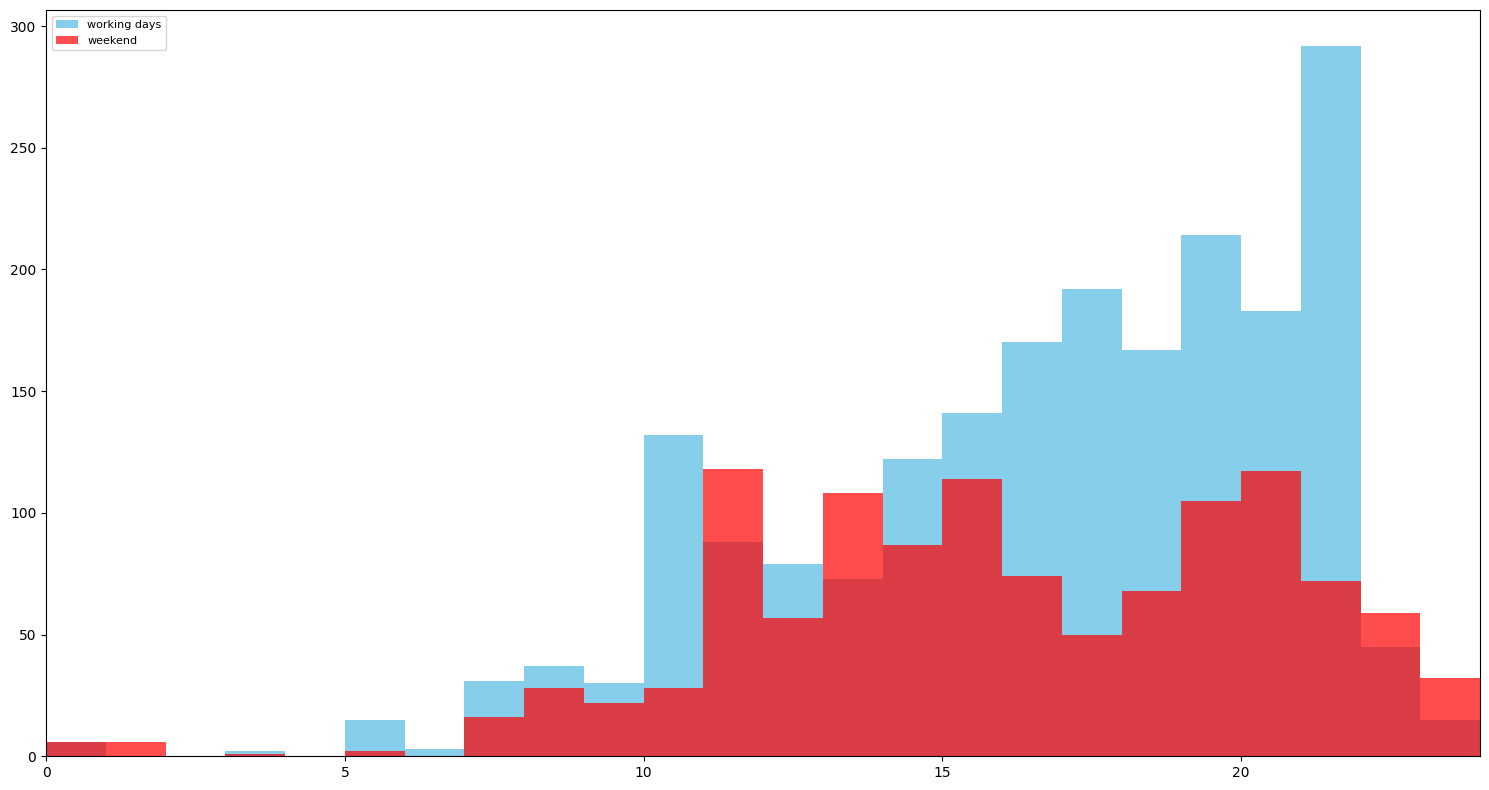

In [13]:
plt.figure(figsize=(15, 8))

plt.hist(
    working_hours,
    bins=24,
    range=(0, 24),
    label='working days',
    color='skyblue'
)

plt.hist(
    weekend_hours,
    bins=24,
    range=(0, 24),
    label='weekend',
    color='red',
    alpha=0.7
)

plt.xticks(range(24))
plt.legend(fontsize=8, loc='upper left')
plt.grid(False)
plt.tight_layout()

plt.xticks(range(0, 25, 5))

plt.xlim(0, 24)
plt.ylim(0, None)

plt.show()


## Закрываем соединение с БД

In [14]:
conn.close()

## Are there hours when the total number of commits was higher on weekends than on working days?

| N | Hour | Difference (weekend - working day)|
|---|------|-----------------------------------|
| 1 | **13**   | 35                                |
| 2 | **11**   | 30                                |
| 3 | **23**   | 17                                |
| 4 | **22**   | 14                                |

In [15]:
working_counts = working_hours.value_counts().sort_index()
weekend_counts = weekend_hours.value_counts().sort_index()

diff = weekend_counts - working_counts
top = diff[diff > 0].sort_values(ascending=False).head(4)
print(top)

hour
13    35.0
11    30.0
23    17.0
22    14.0
Name: count, dtype: float64
